## SVM model for 4class audio with 100ms frame size

## Important Libraries 

In [1]:
import io
import time
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn import svm, datasets
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss

from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Useful Functions

In [2]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

    # Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Read MFCCs feature CSV file of audio of 500ms block

In [3]:
path="/Users/pc/Desktop/SVM+MFCC_newshifting/500ms"
df=pd.read_csv("/Users/pc/Desktop/SVM+MFCC_newshifting/500ms/training/final_500ms.csv",na_values=['NA','?'])
df.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12', 'Label']
filename_write = os.path.join(path,"/Users/pc/Desktop/SVM+MFCC_newshifting/500ms/training/out-of-sample_mySVM_500ms.csv")
df.head()


,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-0.361833,30.413287,14.026782,3.524097,-1.126189,1.995557,-2.024195,6.487043,-0.866477,7.117056,0.499036,4.950554,1.120927,AC & FAN
1,-0.314923,30.727571,14.676690,3.474063,-1.228633,2.278191,-1.999299,6.654512,-0.886767,7.060178,0.484853,4.293945,0.555153,AC & FAN
2,-0.322472,30.330372,14.470898,3.451456,-1.049604,2.263557,-2.018792,6.586320,0.119022,7.385747,0.928325,4.774701,0.638041,AC & FAN
3,-0.242023,30.538032,15.071904,3.793800,-0.413262,2.643561,-2.797349,5.827424,-0.243589,7.820150,2.213806,6.117095,0.799352,AC & FAN
4,-0.247731,30.773976,15.205313,3.309456,-1.786837,2.169586,-2.345875,5.909542,-0.580713,7.892582,1.763518,6.078295,1.073195,AC & FAN


#### Shuffle

In [4]:
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)
df.columns

Index(['MFCC0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7',
       'MFCC8', 'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12', 'Label'],
      dtype='object')

In [5]:
df.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-2.394311,29.810488,13.422348,5.041158,-0.675740,3.085593,-0.737344,5.990743,-2.730853,3.797039,-1.984848,-1.319223,-2.938877,AC & FAN
1,-1.005663,-24.179173,-39.348118,-19.687649,-33.000625,-22.143411,5.512445,-3.212025,-0.127826,-27.297233,-0.793497,-2.717658,16.901237,MUSIC
2,0.389163,-10.897454,-35.689718,-30.623394,-9.579081,-18.441173,3.574754,-9.036672,-8.098490,-18.698142,11.395906,-4.487409,13.965894,MUSIC
3,-0.421217,-5.714487,-5.557554,13.435520,-18.589183,-17.645619,-27.622267,2.044846,-24.317833,2.905796,8.945288,2.933459,-12.077112,SPEECH
4,0.061676,43.293709,10.810026,7.372252,3.384792,-4.271613,-1.987545,2.069687,-0.594472,-2.012608,-3.609498,-2.693153,-1.781564,AC & FAN


#### Sperating Independent variable and Target Variable

In [6]:
X = df[['MFCC0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7',
       'MFCC8', 'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12']]
y = df['Label']

#### Encode to a 2D matrix for training

In [7]:
# Encode to a 2D matrix for training
Label=encode_text_index(df,'Label')
print("Labelling is:{}".format(Label))

Labelling is:['AC & FAN' 'CRYING' 'MUSIC' 'SPEECH']


#### Keeping Holdout Data

In [8]:
# 25 % holdout data
x_main, x_holdout, y_main, y_holdout = train_test_split(X, y, test_size=0.20,random_state = 0)

In [9]:
print("Shape of X : {}".format(X.shape))
print("Shape of y : {}".format(y.shape))
print("Shape of x_main : {}".format(x_main.shape))
print("Shape of x_holdout : {}".format(x_holdout.shape))
print("Shape of y_main : {}".format(y_main.shape))
print("Shape of y_holdout : {}".format(y_holdout.shape))

Shape of X : (575855, 13)
Shape of y : (575855,)
Shape of x_main : (460684, 13)
Shape of x_holdout : (115171, 13)
Shape of y_main : (460684,)
Shape of y_holdout : (115171,)


#### dividing X, y into train and test data

In [10]:
# dividing X, y into train and test data
x_train, x_test, y_train, y_test = train_test_split(x_main, y_main, test_size=0.20,random_state = 0)

In [11]:
print("Shape of x_train : {}".format(x_train.shape))
print("Shape of x_test : {}".format(x_test.shape))
print("Shape of y_train : {}".format(y_train.shape))
print("Shape of y_test : {}".format(y_test.shape))

Shape of x_train : (368547, 13)
Shape of x_test : (92137, 13)
Shape of y_train : (368547,)
Shape of y_test : (92137,)


#### preprocessing of training data, testing data , holdout data

In [12]:
# preprocessing of training data
scaler = preprocessing.StandardScaler().fit(x_train)
#scaler

In [13]:
X_train = scaler.transform(x_train)
X_holdout = scaler.transform(x_holdout) 
# preprocessing of testing data
X_test= scaler.transform(x_test) 

In [14]:
from sklearn.externals import joblib
scaler_file = "my_scaler_500ms.save"
joblib.dump(scaler, scaler_file) 

['my_scaler_500ms.save']

## Model Creation

## RBF kernel

### Training

In [15]:
## RBF kernel training
#### Training
tic=time.time()
svclassifier_rbf = SVC(kernel='rbf',C=1, max_iter=-1,verbose=True,probability=True) 
svclassifier_rbf.fit(X_train, y_train)
#scores = cross_val_score( svclassifier_rbf, X_train, y_train, cv=5,scoring='f1_macro')
toc=time.time()
print(str(1000*(toc-tic))+"ms")

[LibSVM]4544021.376848221ms


### Validation

In [16]:
## Testing

tic=time.time()
y_rbf = svclassifier_rbf.predict(X_test)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

88167.96684265137ms


In [17]:
# model accuracy for X_test  
accuracy = accuracy_score(y_test, y_rbf)
print (accuracy)

0.9796607226195774


In [18]:
## Evaluation of Algorithm
print(confusion_matrix(y_test, y_rbf))  
print(classification_report(y_test, y_rbf))

[[22991     0     1     0]
 [    9 22511   196   355]
 [   16   161 22219   588]
 [    5   195   348 22542]]
             precision    recall  f1-score   support

   AC & FAN       1.00      1.00      1.00     22992
     CRYING       0.98      0.98      0.98     23071
      MUSIC       0.98      0.97      0.97     22984
     SPEECH       0.96      0.98      0.97     23090

avg / total       0.98      0.98      0.98     92137



### Saving RBF kernel Trained Model

In [19]:
# save the model to disk
filename = 'SVM_500ms_Rbf_model.save'
joblib.dump(svclassifier_rbf, open(filename, 'wb'))

In [20]:
 # load the model from disk
loaded_model_rbf = joblib.load(open(filename, 'rb'))

### Holdout Predction

In [21]:
tic=time.time()
holdout_pred_rbf = loaded_model_rbf.predict(X_holdout)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

110293.42222213745ms


In [22]:
rbf_score = accuracy_score(y_holdout, holdout_pred_rbf)
print("Holdout accuracy with rbf kernel is: {}".format(rbf_score))

Holdout accuracy with rbf kernel is: 0.9788401594151306


In [23]:
## Turn off the scintific notation 
np.set_printoptions(suppress=True)

Confusion matrix, without normalization
[[28760     0     0     0]
 [    8 28024   272   409]
 [   20   213 27757   761]
 [   13   254   487 28193]]


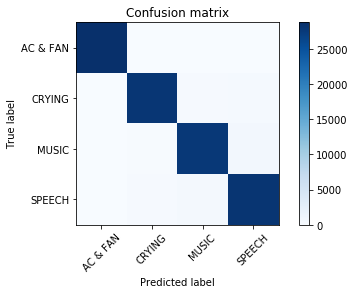

In [24]:
cm = confusion_matrix(y_holdout, holdout_pred_rbf)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, Label)
plt.savefig('cm_holdout_mySVM_500ms_mani_rbf.png',dpi=150)

Confusion matrix, without normalization


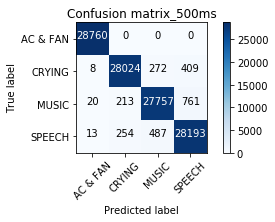

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_holdout, holdout_pred_rbf)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(5,3))
plot_confusion_matrix(cnf_matrix, classes=['AC & FAN', 'CRYING','MUSIC', 'SPEECH'],
                      title='Confusion matrix_500ms')

plt.savefig('mani1_svm_500ms.png')

In [26]:
print(classification_report(y_holdout, holdout_pred_rbf))

             precision    recall  f1-score   support

   AC & FAN       1.00      1.00      1.00     28760
     CRYING       0.98      0.98      0.98     28713
      MUSIC       0.97      0.97      0.97     28751
     SPEECH       0.96      0.97      0.97     28947

avg / total       0.98      0.98      0.98    115171



In [27]:
model_prob_rbf = loaded_model_rbf.predict_proba(X_holdout) ##need prob for getting logloss
rbf_log_loss = log_loss(y_holdout, model_prob_rbf)
print("Log loss score of Holdout data for RBF kernel: {}".format(rbf_log_loss))

Log loss score of Holdout data for RBF kernel: 0.0635966241232474


## Loading Saved Model

In [2]:
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import time

In [3]:
filename = 'SVM_500ms_Rbf_model.save' # call first saved model file

In [4]:
 # load the model from disk
loaded_model_rbf1 = joblib.load(open(filename, 'rb'))

### A

In [9]:
df1=pd.read_csv("/Users/pc/Desktop/SVM+MFCC_newshifting/500ms/testing/crytest_500ms.csv",na_values=['NA','?'])
df1.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
#filename_write = os.path.join(path,"7class-out-of-sample_mySVM_500ms.csv")
df1.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,0.608042,-30.940753,-27.159607,5.345244,25.946790,-6.822781,-13.691598,7.267448,-6.761558,18.124799,-21.399074,-5.863374,26.848989
1,2.566048,-38.049089,-42.226694,-17.603180,-2.100800,-19.395015,-13.348083,13.026216,7.050743,20.365930,-24.065191,0.415657,20.892712
2,2.578959,-40.044976,-45.729119,-22.430032,-7.769700,-25.052723,-19.106227,7.284098,1.478592,14.785409,-29.064009,-4.092647,16.663434
3,2.979923,-34.028767,-41.768890,-26.959979,-15.497842,-11.995418,-1.491131,24.434800,1.733556,9.399367,-29.313156,-4.852593,25.135717
4,3.486683,-31.588030,-38.511233,-25.265812,-14.348102,0.705937,3.463126,26.816061,-10.173797,15.004500,-19.319196,1.847799,26.732329


In [11]:
scaler_file = "my_scaler_500ms.save"
scaler = joblib.load(scaler_file) 

In [12]:
X = scaler.transform(df1) ## Performing preprocessing on tested data

In [13]:
tic=time.time()
holdout_pred_rbf1 = loaded_model_rbf1.predict(X)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

72024.11961555481ms


In [21]:
p1=holdout_pred_rbf1.size
print("The size of prediction " + str (p1))
a1=sum(holdout_pred_rbf1=="SPEECH")
print("Total no. of predcited Crying "+str(a1))
Acc1=a1/p1*100
print("The accuracy of the new environment crying data is "+ str(Acc1)+ " percent")

The size of prediction 71981
Total no. of predcited Crying 7705
The accuracy of the new environment crying data is 10.704213611925368 percent


### V

In [28]:
df6=pd.read_csv("/Users/pc/Desktop/SVM+MFCC_newshifting/500ms/testing/musictest_500ms.csv",na_values=['NA','?'])
df6.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
#filename_write = os.path.join(path,"7class-out-of-sample_mySVM_500ms.csv")

X6= scaler.transform(df6) ## Direct Do this
tic=time.time()
holdout_pred_rbf6 = loaded_model_rbf1.predict(X6)
toc=time.time()
print(str(1000*(toc-tic))+"ms")
p6=holdout_pred_rbf6.size
print("The size of prediction " + str (p6))
a6=sum(holdout_pred_rbf6=="SPEECH")
print("Total no. of predcited music "+str(a6))
Acc6=a6/p6*100
print("The accuracy of the new environment music data is "+ str(Acc6)+ " percent")

70787.04881668091ms
The size of prediction 71981
Total no. of predcited music 8116
The accuracy of the new environment music data is 11.275197621594588 percent


In [29]:
df7=pd.read_csv("/Users/pc/Desktop/SVM+MFCC_newshifting/500ms/testing/speechtest_500ms.csv",na_values=['NA','?'])
df7.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
#filename_write = os.path.join(path,"7class-out-of-sample_mySVM_500ms.csv")
df7.head()
X7= scaler.transform(df7) ## Direct Do this
tic=time.time()
holdout_pred_rbf7 = loaded_model_rbf1.predict(X7)
toc=time.time()
print(str(1000*(toc-tic))+"ms")
p7=holdout_pred_rbf7.size
print("The size of prediction " + str (p7))
a7=sum(holdout_pred_rbf7=="AC & FAN")
print("Total no. of predcited speech "+str(a7))
Acc7=a7/p7*100
print("The accuracy of the new environment speech data is "+ str(Acc7)+ " percent")

70854.05278205872ms
The size of prediction 71981
Total no. of predcited speech 1733
The accuracy of the new environment speech data is 2.4075797779969714 percent


#### S

In [31]:
df8=pd.read_csv("/Users/pc/Desktop/SVM+MFCC_newshifting/500ms/testing/fanactest_500ms.csv",na_values=['NA','?'])
df8.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
#filename_write = os.path.join(path,"7class-out-of-sample_mySVM_500ms.csv")
df8.head()
X8= scaler.transform(df8) ## Direct Do this
tic=time.time()
holdout_pred_rbf8 = loaded_model_rbf1.predict(X8)
toc=time.time()
print(str(1000*(toc-tic))+"ms")
p8=holdout_pred_rbf8.size
print("The size of prediction " + str (p8))
a8=sum(holdout_pred_rbf8=="SPEECH")
print("Total no. of predcited AC & FAN "+str(a8))
Acc8=a8/p8*100
print("The accuracy of the new environment AC & FAN data is "+ str(Acc8)+ " percent")

70260.01858711243ms
The size of prediction 71981
Total no. of predcited AC & FAN 60
The accuracy of the new environment AC & FAN data is 0.08335532987871799 percent
